In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv('main_data_ver2.csv')

In [3]:
print(df.shape)
df.head()

(4560736, 24)


,시군구,번지,본번,부번,건물명,전월세매매구분,전용면적(㎡),계약년월,계약일,금액(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,동,건물종류,trade_type
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),매매,77.75,201309,8,57000,0,2,1988,언주로 103,733.118971,2013,9,서울특별시,강남구,10.950807,6.597308,서울특별시 강남구 개포동,아파트,아파트_매매
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),매매,77.75,201312,16,57000,0,2,1988,언주로 103,733.118971,2013,12,서울특별시,강남구,10.950807,6.597308,서울특별시 강남구 개포동,아파트,아파트_매매
2,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,매매,67.28,201302,11,55000,0,5,1987,언주로 3,817.479191,2013,2,서울특별시,강남구,10.915088,6.706225,서울특별시 강남구 개포동,아파트,아파트_매매
3,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,매매,67.28,201302,22,58250,0,4,1987,언주로 3,865.784780,2013,2,서울특별시,강남구,10.972499,6.763636,서울특별시 강남구 개포동,아파트,아파트_매매
4,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,매매,67.28,201305,10,60000,0,5,1987,언주로 3,891.795482,2013,5,서울특별시,강남구,11.002100,6.793237,서울특별시 강남구 개포동,아파트,아파트_매매


In [4]:
df['전용면적(㎡)'].describe()

count    4.560736e+06
mean     6.348465e+01
std      3.050379e+01
min      1.000000e+00
25%      4.130000e+01
50%      5.985000e+01
75%      8.475000e+01
max      5.792700e+02
Name: 전용면적(㎡), dtype: float64

<AxesSubplot:>

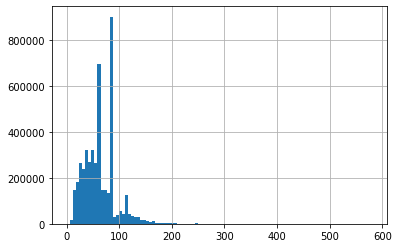

In [5]:
df['전용면적(㎡)'].hist(bins=100)

In [6]:
df[df['전용면적(㎡)'] == df['전용면적(㎡)'].max()]

,시군구,번지,본번,부번,건물명,전월세매매구분,전용면적(㎡),계약년월,계약일,금액(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,동,건물종류,trade_type
4271645,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,579.27,200807,31,333751,0,14,2006,새창로 217,576.157923,2008,7,서울특별시,용산구,12.71815,6.356382,서울특별시 용산구 한강로,오피스텔,오피스텔_매매


In [7]:
building_df = df[df['건물명'] == '용산 토투벨리']
building_df.shape

(101, 24)

In [8]:
building_df

,시군구,번지,본번,부번,건물명,전월세매매구분,전용면적(㎡),계약년월,계약일,금액(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,동,건물종류,trade_type
4269592,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,56.29,201408,9,33000,0,11,2006,새창로 217,586.249778,2014,8,서울특별시,용산구,10.404263,6.373746,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4269727,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,54.23,201503,9,29000,0,12,2006,새창로 217,534.759358,2015,3,서울특별시,용산구,10.275051,6.281817,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4269728,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,54.23,201511,3,30800,0,10,2006,새창로 217,567.951318,2015,11,서울특별시,용산구,10.335270,6.342036,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4269999,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,37.85,201601,28,22600,0,11,2006,새창로 217,597.093791,2016,1,서울특별시,용산구,10.025705,6.392074,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4270000,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,47.99,201605,6,29000,0,11,2006,새창로 217,604.292561,2016,5,서울특별시,용산구,10.275051,6.404058,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4270001,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,33.93,201605,13,21500,0,11,2006,새창로 217,633.657530,2016,5,서울특별시,용산구,9.975808,6.451509,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4270002,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,47.99,201606,23,29000,0,12,2006,새창로 217,604.292561,2016,6,서울특별시,용산구,10.275051,6.404058,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4270003,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,47.99,201609,28,30800,0,10,2006,새창로 217,641.800375,2016,9,서울특별시,용산구,10.335270,6.464277,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4270234,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,52.19,201703,8,34500,0,13,2006,새창로 217,661.046177,2017,3,서울특별시,용산구,10.448715,6.493824,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
4270235,서울특별시 용산구 한강로2가,2-37,2,37,용산 토투벨리,매매,47.99,201708,21,31500,0,11,2006,새창로 217,656.386747,2017,8,서울특별시,용산구,10.357743,6.486750,서울특별시 용산구 한강로,오피스텔,오피스텔_매매
